## EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)
from pyspark.sql.functions import *

In [2]:
import geopandas as gpd

In [3]:
from pandas.tseries.holiday import USFederalHolidayCalendar

In [3]:
sc = SparkContext.getOrCreate();
spark = SparkSession(sc)

In [4]:
df = spark.read.csv("gs://airline_bigdata/Data/flights_clean/part-00000-03165d74-a60b-47b0-90f8-0e5d9a7bbc33-c000.csv", header=True)

In [5]:
df

22/03/01 22:56:55 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,OR_AIRPORT_NAME,OR_CITY,OR_COUNTRY,OR_AIRPORT_CODE,OR_LATITUDE,OR_LONGTITUDE,DES_AIRPORT_NAME,DES_CITY,DES_COUNTRY,DES_AIRPORT_CODE,DES_LATITUDE,DES_LONGTITUDE
2009-01-01,XE,1204,DCA,EWR,1100,1058.0,-2.0,18.0,1116.0,1158.0,8.0,1202,1206.0,4.0,0.0,0.0,62.0,68.0,42.0,199.0,Ronald Reagan Was...,Washington,United States,DCA,38.8521,-77.037697,Newark Liberty In...,Newark,United States,EWR,40.692501068115234,-74.168701171875
2009-01-01,XE,1206,EWR,IAD,1510,1509.0,-1.0,28.0,1537.0,1620.0,4.0,1632,1624.0,-8.0,0.0,0.0,82.0,75.0,43.0,213.0,Newark Liberty In...,Newark,United States,EWR,40.692501068115234,-74.168701171875,Washington Dulles...,Washington,United States,IAD,38.94449997,-77.45580292
2009-01-01,XE,1207,EWR,DCA,1100,1059.0,-1.0,20.0,1119.0,1155.0,6.0,1210,1201.0,-9.0,0.0,0.0,70.0,62.0,36.0,199.0,Newark Liberty In...,Newark,United States,EWR,40.692501068115234,-74.168701171875,Ronald Reagan Was...,Washington,United States,DCA,38.8521,-77.037697
2009-01-01,XE,1208,DCA,EWR,1240,1249.0,9.0,10.0,1259.0,1336.0,9.0,1357,1345.0,-12.0,0.0,0.0,77.0,56.0,37.0,199.0,Ronald Reagan Was...,Washington,United States,DCA,38.8521,-77.037697,Newark Liberty In...,Newark,United States,EWR,40.692501068115234,-74.168701171875
2009-01-01,XE,1209,IAD,EWR,1715,1705.0,-10.0,24.0,1729.0,1809.0,13.0,1900,1822.0,-38.0,0.0,0.0,105.0,77.0,40.0,213.0,Washington Dulles...,Washington,United States,IAD,38.94449997,-77.45580292,Newark Liberty In...,Newark,United States,EWR,40.692501068115234,-74.168701171875
2009-01-01,XE,1212,ATL,EWR,1915,1913.0,-2.0,19.0,1932.0,2108.0,15.0,2142,2123.0,-19.0,0.0,0.0,147.0,130.0,96.0,745.0,Hartsfield Jackso...,Atlanta,United States,ATL,33.6367,-84.428101,Newark Liberty In...,Newark,United States,EWR,40.692501068115234,-74.168701171875
2009-01-01,XE,1212,CLE,ATL,1645,1637.0,-8.0,12.0,1649.0,1820.0,5.0,1842,1825.0,-17.0,0.0,0.0,117.0,108.0,91.0,554.0,Cleveland Hopkins...,Cleveland,United States,CLE,41.4117012024,-81.8498001099,Hartsfield Jackso...,Atlanta,United States,ATL,33.6367,-84.428101
2009-01-01,XE,1214,DCA,EWR,1915,1908.0,-7.0,9.0,1917.0,1953.0,34.0,2035,2027.0,-8.0,0.0,0.0,80.0,79.0,36.0,199.0,Ronald Reagan Was...,Washington,United States,DCA,38.8521,-77.037697,Newark Liberty In...,Newark,United States,EWR,40.692501068115234,-74.168701171875
2009-01-01,XE,1215,EWR,DCA,1715,1710.0,-5.0,28.0,1738.0,1819.0,4.0,1838,1823.0,-15.0,0.0,0.0,83.0,73.0,41.0,199.0,Newark Liberty In...,Newark,United States,EWR,40.692501068115234,-74.168701171875,Ronald Reagan Was...,Washington,United States,DCA,38.8521,-77.037697
2009-01-01,XE,1217,EWR,DCA,1300,1255.0,-5.0,15.0,1310.0,1349.0,7.0,1408,1356.0,-12.0,0.0,0.0,68.0,61.0,39.0,199.0,Newark Liberty In...,Newark,United States,EWR,40.692501068115234,-74.168701171875,Ronald Reagan Was...,Washington,United States,DCA,38.8521,-77.037697


Notice that there are some perfect correlations:

1. `DEP_TIME` - `CRS_DEP_TIME` = `DEP_DELAY`

2. `DEP_TIME` + `TAXI_OUT` = `WHEELS_OFF`

3. `WHEELS_ON` + `TAXI_IN` = `ARR_TIME`

4. `AIR_TIME`+ `TAXI_IN` + `TAXI_OUT` = `ACTUAL_ELAPSED_TIME`

We will drop some columns to remove multicollinearity in our columns.

In [5]:
df = df.drop('DEP_TIME', 'ARR_TIME','WHEELS_OFF','WHEELS_ON', 'ACTUAL_ELAPSED_TIME')

###  Shape and Data Types

In [7]:
print(df.count(), 'rows and ', len(df.columns), 'columns.')

59820608 rows and  33 columns.


In [7]:
df.printSchema()

root
 |-- FL_DATE: string (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: string (nullable = true)
 |-- DEP_DELAY: string (nullable = true)
 |-- TAXI_OUT: string (nullable = true)
 |-- TAXI_IN: string (nullable = true)
 |-- CRS_ARR_TIME: string (nullable = true)
 |-- ARR_DELAY: string (nullable = true)
 |-- CANCELLED: string (nullable = true)
 |-- DIVERTED: string (nullable = true)
 |-- CRS_ELAPSED_TIME: string (nullable = true)
 |-- AIR_TIME: string (nullable = true)
 |-- DISTANCE: string (nullable = true)
 |-- OR_AIRPORT_NAME: string (nullable = true)
 |-- OR_CITY: string (nullable = true)
 |-- OR_COUNTRY: string (nullable = true)
 |-- OR_AIRPORT_CODE: string (nullable = true)
 |-- OR_LATITUDE: string (nullable = true)
 |-- OR_LONGTITUDE: string (nullable = true)
 |-- DES_AIRPORT_NAME: string (nullable = true)
 |-- DES_CITY: string 

### Convert columns to correct data types

In [6]:
# Dates
df = df.withColumn("FL_DATE",to_date(col("FL_DATE"),"yyyy-MM-dd"))
# Change time to integers, larger number indicates later into the day
# Change column measure in minutes to int
df = df.withColumn("CRS_DEP_TIME",df.CRS_DEP_TIME.cast('int'))
df = df.withColumn("CRS_ARR_TIME",df.CRS_ARR_TIME.cast('int'))
df = df.withColumn("DEP_DELAY",df.DEP_DELAY.cast('double'))
df = df.withColumn("ARR_DELAY",df.ARR_DELAY.cast('double'))
df = df.withColumn("CRS_ELAPSED_TIME",df.CRS_ELAPSED_TIME.cast('int'))
df = df.withColumn("AIR_TIME",df.AIR_TIME.cast('double'))
df = df.withColumn("DISTANCE",df.DISTANCE.cast('double'))

# Change long, lattitude to doulbe
df = df.withColumn("OR_LATITUDE",df.OR_LATITUDE.cast('double'))
df = df.withColumn("OR_LONGTITUDE",df.OR_LONGTITUDE.cast('double'))
df = df.withColumn("DES_LATITUDE",df.DES_LATITUDE.cast('double'))
df = df.withColumn("DES_LONGTITUDE",df.DES_LONGTITUDE.cast('double'))
df = df.withColumn("TAXI_OUT",df.TAXI_OUT.cast('double'))
df = df.withColumn("TAXI_IN",df.TAXI_IN.cast('double'))


# Change distance, air_time to double
# Change arrest and domestic into Boolean
df = df.withColumn('CANCELLED', df.CANCELLED.cast('boolean'))
df = df.withColumn('DIVERTED', df.DIVERTED.cast('boolean'))
df.dtypes

[('FL_DATE', 'date'),
 ('OP_CARRIER', 'string'),
 ('OP_CARRIER_FL_NUM', 'string'),
 ('ORIGIN', 'string'),
 ('DEST', 'string'),
 ('CRS_DEP_TIME', 'int'),
 ('DEP_DELAY', 'double'),
 ('TAXI_OUT', 'double'),
 ('TAXI_IN', 'double'),
 ('CRS_ARR_TIME', 'int'),
 ('ARR_DELAY', 'double'),
 ('CANCELLED', 'boolean'),
 ('DIVERTED', 'boolean'),
 ('CRS_ELAPSED_TIME', 'int'),
 ('AIR_TIME', 'double'),
 ('DISTANCE', 'double'),
 ('OR_AIRPORT_NAME', 'string'),
 ('OR_CITY', 'string'),
 ('OR_COUNTRY', 'string'),
 ('OR_AIRPORT_CODE', 'string'),
 ('OR_LATITUDE', 'double'),
 ('OR_LONGTITUDE', 'double'),
 ('DES_AIRPORT_NAME', 'string'),
 ('DES_CITY', 'string'),
 ('DES_COUNTRY', 'string'),
 ('DES_AIRPORT_CODE', 'string'),
 ('DES_LATITUDE', 'double'),
 ('DES_LONGTITUDE', 'double')]

### Create our target variable Delay for predictions

Note that there are two types of delays: departure delay and arrival delay. For us to frame this to be a regression problem, we will be creating a new variable `AVG_DELAY` as the average of the two for our target variable.

In [7]:
df = df.withColumn('AVG_DELAY',((col("DEP_DELAY") + col("ARR_DELAY")) / lit(2)))

### Numerical Features

In [11]:
df.select('CRS_DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_DELAY','CRS_ELAPSED_TIME','AIR_TIME','DISTANCE','AVG_DELAY').summary()

summary,CRS_DEP_TIME,DEP_DELAY,TAXI_OUT,TAXI_IN,CRS_ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,AIR_TIME,DISTANCE,AVG_DELAY
count,59820609,59820609,59820609,59820609,59820609,59820609,59820609,59820609,59820609,59820609
mean,1326.9278572372943,8.973608777536851,15.980871809579872,7.1121389620088955,1494.9461948306143,4.692962537375706,136.4157424910201,109.04211929704694,782.3014194990893,6.833285657456279
stddev,474.47630404149135,36.91803879940103,9.305866011732835,5.283297911722167,495.0673965810745,39.390844419609856,73.26401024007399,70.44791902775235,592.4537913741324,37.61926887433476
min,1,-226.0,1.0,0.0,1,-411.0,-99,3.0,11.0,-318.5
25%,921,-5.0,10.0,4.0,1113,-13.0,84,58.0,351.0,-8.5
50%,1320,-2.0,14.0,6.0,1519,-4.0,117,90.0,612.0,-3.0
75%,1725,7.0,19.0,8.0,1913,8.0,166,138.0,1009.0,6.5
max,2359,2710.0,458.0,414.0,2400,2692.0,718,723.0,4983.0,2701.0


We see that most of the flights are scheduled around the middle of the day. The distributions for DEP_DELAY and ARR_DELAY are clearly heavily right skewed as flights can delay for up to 2 days but would never arrive a day or even half a day earlier. We also see that there are some rare and long flights with distance greater than 4000. Most of the numericla features have right skewed distributions.

### Correlation Plots

In [11]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

df_cor = df.select('CRS_DEP_TIME', 'TAXI_OUT', 'TAXI_IN', 'CRS_ARR_TIME','CRS_ELAPSED_TIME','AIR_TIME','DISTANCE','AVG_DELAY')

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_cor.columns, outputCol=vector_col)
df_vector = assembler.transform(df_cor).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

In [17]:
corrmatrix = matrix.collect()[0][0].toArray().tolist()
print(corrmatrix)

[[1.0, 0.01152577482370013, -0.04768386015884415, 0.7456008785016887, -0.013420402011865841, -0.014971201659519314, -0.00806055011759942, 0.11202636737949218], [0.01152577482370013, 1.0, 0.0329984468569378, 0.029387776249308568, 0.12488898686750018, 0.09455116436027045, 0.08007341405301387, 0.154877675042139], [-0.04768386015884415, 0.0329984468569378, 1.0, -0.01053381426890416, 0.11215367449319896, 0.09147756458494624, 0.08479386705365852, 0.06070775910386495], [0.7456008785016887, 0.029387776249308568, -0.01053381426890416, 1.0, 0.04185332935843811, 0.03785012732714926, 0.037756727204759824, 0.10275054752860947], [-0.013420402011865841, 0.12488898686750018, 0.11215367449319896, 0.04185332935843811, 1.0, 0.9895684428308109, 0.9839664309642595, -0.003452435286854263], [-0.014971201659519314, 0.09455116436027045, 0.09147756458494624, 0.03785012732714926, 0.9895684428308109, 1.0, 0.984983318465498, 0.006998695763519739], [-0.00806055011759942, 0.08007341405301387, 0.08479386705365852, 0.

In [22]:
corr_df

,CRS_DEP_TIME,TAXI_OUT,TAXI_IN,CRS_ARR_TIME,CRS_ELAPSED_TIME,AIR_TIME,DISTANCE,AVG_DELAY
CRS_DEP_TIME,1.000000,0.011526,-0.047684,0.745601,-0.013420,-0.014971,-0.008061,0.112026
TAXI_OUT,0.011526,1.000000,0.032998,0.029388,0.124889,0.094551,0.080073,0.154878
TAXI_IN,-0.047684,0.032998,1.000000,-0.010534,0.112154,0.091478,0.084794,0.060708
CRS_ARR_TIME,0.745601,0.029388,-0.010534,1.000000,0.041853,0.037850,0.037757,0.102751
CRS_ELAPSED_TIME,-0.013420,0.124889,0.112154,0.041853,1.000000,0.989568,0.983966,-0.003452
AIR_TIME,-0.014971,0.094551,0.091478,0.037850,0.989568,1.000000,0.984983,0.006999
DISTANCE,-0.008061,0.080073,0.084794,0.037757,0.983966,0.984983,1.000000,-0.003903
AVG_DELAY,0.112026,0.154878,0.060708,0.102751,-0.003452,0.006999,-0.003903,1.000000


<AxesSubplot:>

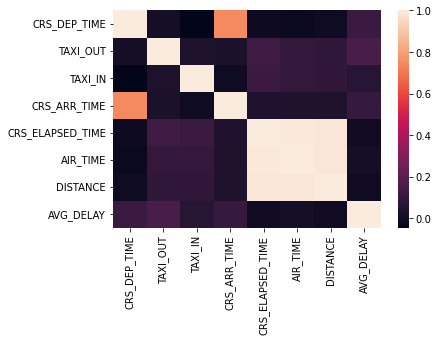

In [21]:
import seaborn as sns
corr_df = pd.DataFrame(corrmatrix, columns = ['CRS_DEP_TIME', 'TAXI_OUT', 'TAXI_IN', 'CRS_ARR_TIME','CRS_ELAPSED_TIME','AIR_TIME','DISTANCE','AVG_DELAY'],
                      index = ['CRS_DEP_TIME', 'TAXI_OUT', 'TAXI_IN', 'CRS_ARR_TIME','CRS_ELAPSED_TIME','AIR_TIME','DISTANCE','AVG_DELAY'])
sns.heatmap(corr_df)

In [23]:
corr_df

,CRS_DEP_TIME,TAXI_OUT,TAXI_IN,CRS_ARR_TIME,CRS_ELAPSED_TIME,AIR_TIME,DISTANCE,AVG_DELAY
CRS_DEP_TIME,1.000000,0.011526,-0.047684,0.745601,-0.013420,-0.014971,-0.008061,0.112026
TAXI_OUT,0.011526,1.000000,0.032998,0.029388,0.124889,0.094551,0.080073,0.154878
TAXI_IN,-0.047684,0.032998,1.000000,-0.010534,0.112154,0.091478,0.084794,0.060708
CRS_ARR_TIME,0.745601,0.029388,-0.010534,1.000000,0.041853,0.037850,0.037757,0.102751
CRS_ELAPSED_TIME,-0.013420,0.124889,0.112154,0.041853,1.000000,0.989568,0.983966,-0.003452
AIR_TIME,-0.014971,0.094551,0.091478,0.037850,0.989568,1.000000,0.984983,0.006999
DISTANCE,-0.008061,0.080073,0.084794,0.037757,0.983966,0.984983,1.000000,-0.003903
AVG_DELAY,0.112026,0.154878,0.060708,0.102751,-0.003452,0.006999,-0.003903,1.000000


We see high correlations among `CRS_ELAPSED_TIME`, `AIR_TIME`, AND `DISTANCE`. This is expected since the longer the distance the longer 

### Categorical Features

#### Airports

Since aircrafts rarely perform a one-way trip, airport traffic indicated by origin reflects the same pattern by destination as well.

<BarContainer object of 11 artists>

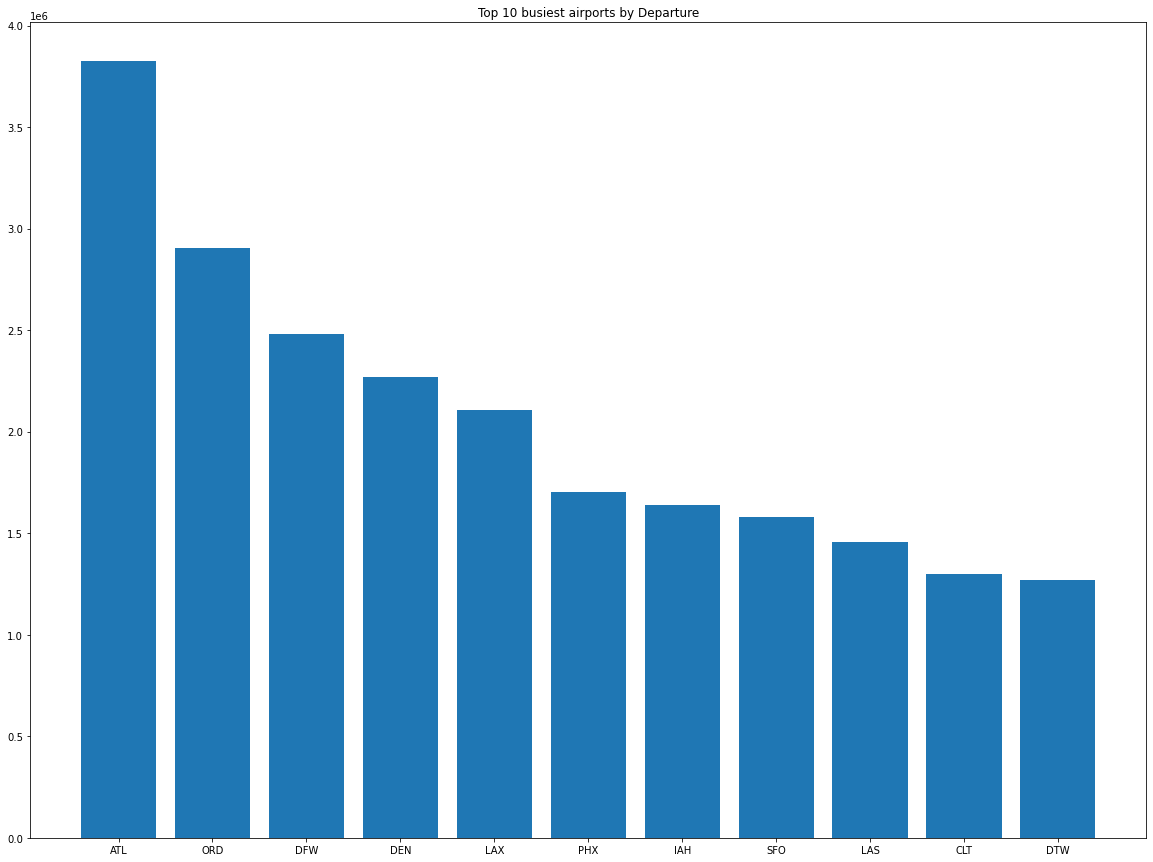

In [12]:
# Top 11 busiest airports by departure 
df_temp = df.groupby('ORIGIN').count().orderBy('count', ascending = [0]).toPandas()
plt.subplots(figsize = (20,15))
plt.title('Top 10 busiest airports by Departure')
plt.bar(df_temp['ORIGIN'][0:11], df_temp['count'][0:11])

We see that the top 4 most visited airports are all around the middle region of the United States. This may be due to the fact
that these airports are often used as stops for a longer flight. 

### Compare delay time of the top 5 busiest airport

#### Atlanta

In [10]:
atl_avg_delay = df.filter((df.ORIGIN == 'ATL') | (df.DEST == 'ATL')).agg({"AVG_DELAY": "mean"})

In [11]:
atl_avg_delay

avg(AVG_DELAY)
6.4617583449479765


#### O'Hare

In [12]:
ord_avg_delay = df.filter((df.ORIGIN == 'ORD') | (df.DEST == 'ORD')).agg({"AVG_DELAY": "mean"})
ord_avg_delay

avg(AVG_DELAY)
9.670765440714371


#### Dallas/Fort Worth

In [13]:
dfw_avg_delay = df.filter((df.ORIGIN == 'DFW') | (df.DEST == 'DFW')).agg({"AVG_DELAY": "mean"})
dfw_avg_delay

avg(AVG_DELAY)
8.118038905544504


#### DEN

In [14]:
den_avg_delay = df.filter((df.ORIGIN == 'DEN') | (df.DEST == 'DEN')).agg({"AVG_DELAY": "mean"})
den_avg_delay

avg(AVG_DELAY)
6.92933160211192


#### LAX

In [17]:
lax_avg_delay = df.filter((df.ORIGIN == 'LAX') | (df.DEST == 'LAX')).agg({"AVG_DELAY": "mean"})
lax_avg_delay

avg(AVG_DELAY)
6.613231685333147


Interestingly, we see that Atlanta airport that has the most number of visit doesn't actually have the longest delay on average. In fact, O'hare that has about a million less visits than Atlanta has the highest delay on average among the 5. This can be due to how O'hare often has long-delayed flights due to weather conditions in the winter. Perhaps we should add a feature indicating what season it is. 

### Extract Seasons from Date

In [8]:
from pyspark.sql.functions import when
df = df.withColumn("Season", \
   when((month(df.FL_DATE) >= 3) & (month(df.FL_DATE) <= 5), lit("Spring")) \
     .when((month(df.FL_DATE) >= 6) & (month(df.FL_DATE) <= 8), lit("Summer")) \
.when((month(df.FL_DATE) >= 9) & (month(df.FL_DATE) <= 11), lit("Fall")) \
     .otherwise(lit("Winter")) \
  )

### Airlines

<BarContainer object of 5 artists>

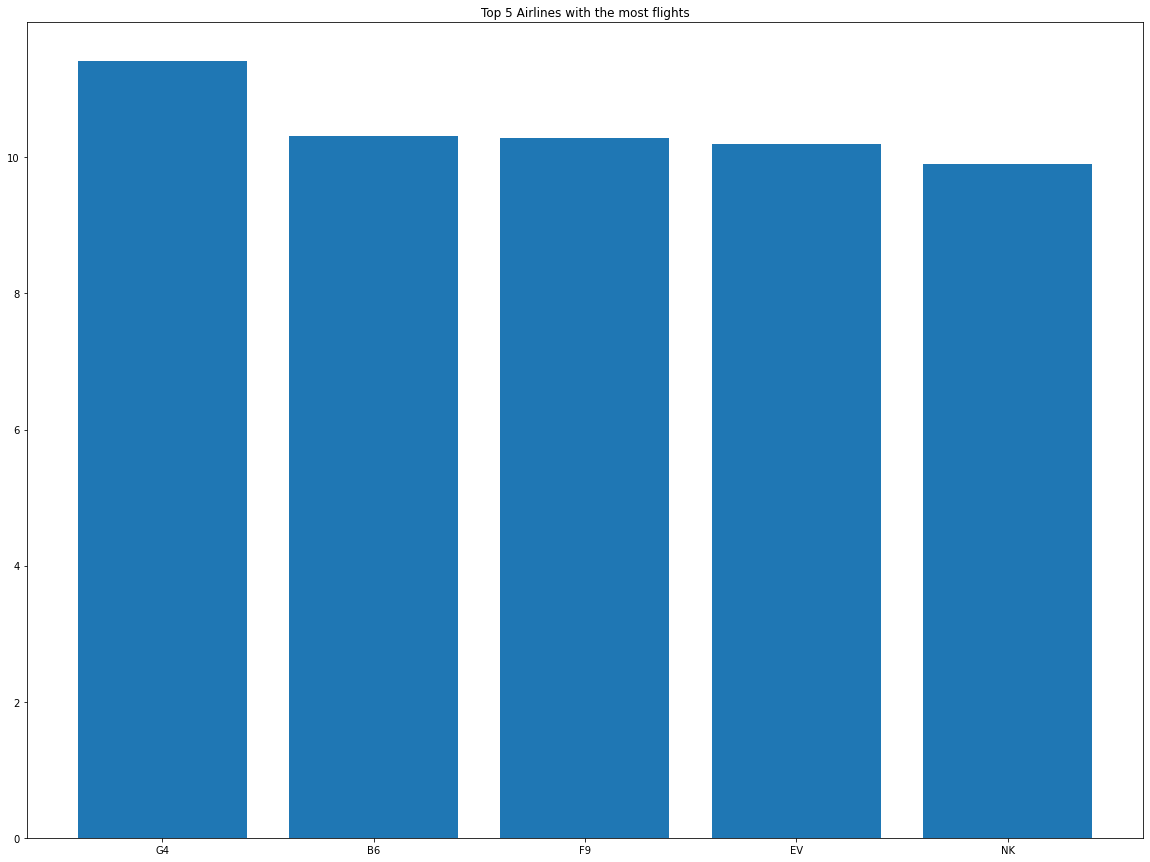

In [20]:
# Top 5 Airlines with the longest average delays 
df_temp = df.groupby('OP_CARRIER').agg({"AVG_DELAY": "mean"}).orderBy('avg(AVG_DELAY)', ascending=[0]).toPandas()
plt.subplots(figsize = (20,15))
plt.title('Top 5 Airlines with the most flights')
plt.bar(df_temp['OP_CARRIER'][0:5], df_temp['avg(AVG_DELAY)'][0:5])

We see that airline like Allegiant (G4), Frontier (F9), and Spirit (NK) are all low-cost airlines that utilize strategies of minizing their cost at the expense of customer experience. JetBlue (B6) also has long delayd due to its frequent visit to JFK, which is a popular hub for international flights. And Eva (EV) is an international airline and probably has less access of airport gates in the United States.   

### Plot Time-Series for Longest-delayed Airlines

In [9]:
# Extract yer and month from Fl_DATE

df= df.withColumn('Year', year(col("FL_DATE")))
df = df.withColumn('Month', month(col("FL_DATE")))

In [24]:
df_G4 = df.filter(df.OP_CARRIER == 'G4').groupby('Year','Month').agg({"AVG_DELAY":"mean"}).orderBy(['Year', 'Month']).toPandas()


In [25]:
df_B6 = df.filter(df.OP_CARRIER == 'B6').groupby('Year','Month').agg({"AVG_DELAY":"mean"}).orderBy(['Year', 'Month']).toPandas()


In [26]:
df_F9 = df.filter(df.OP_CARRIER == 'F9').groupby('Year','Month').agg({"AVG_DELAY":"mean"}).orderBy(['Year', 'Month']).toPandas()


In [27]:
df_EV = df.filter(df.OP_CARRIER == 'EV').groupby('Year','Month').agg({"AVG_DELAY":"mean"}).orderBy(['Year', 'Month']).toPandas()


In [28]:
df_NK = df.filter(df.OP_CARRIER == 'NK').groupby('Year','Month').agg({"AVG_DELAY":"mean"}).orderBy(['Year', 'Month']).toPandas()


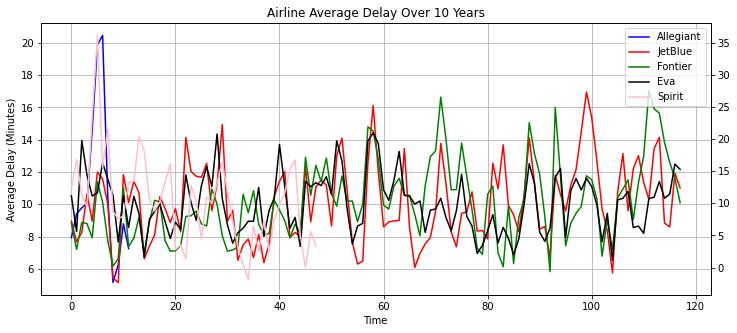

In [30]:
plt.figure(figsize=(12,5))
plt.xlabel('Time')
plt.ylabel('Average Delay (Minutes)')
plt.title("Airline Average Delay Over 10 Years")

ax1 = df_G4['avg(AVG_DELAY)'].plot(color='blue', grid=True, label='Allegiant')
ax2 = df_B6['avg(AVG_DELAY)'].plot(color='red', grid=True, secondary_y=True, label='JetBlue')
ax3 = df_F9['avg(AVG_DELAY)'].plot(color='green', grid=True, secondary_y=True, label='Fontier')
ax4 = df_EV['avg(AVG_DELAY)'].plot(color='black', grid=True, secondary_y=True, label='Eva')
ax5 = df_NK['avg(AVG_DELAY)'].plot(color='pink', grid=True, secondary_y=True, label='Spirit')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
h3, l3 = ax3.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=1)
plt.show()

We see that Spirit and Allegiant have really high average delays while JetBlue and Frontier have similar average delay over time. Among the 5, Eva seems to have the most consistent average delay, indicate that it has better aircraft management than others.

### Plot Time series for top 5 most popular airlines

<BarContainer object of 5 artists>

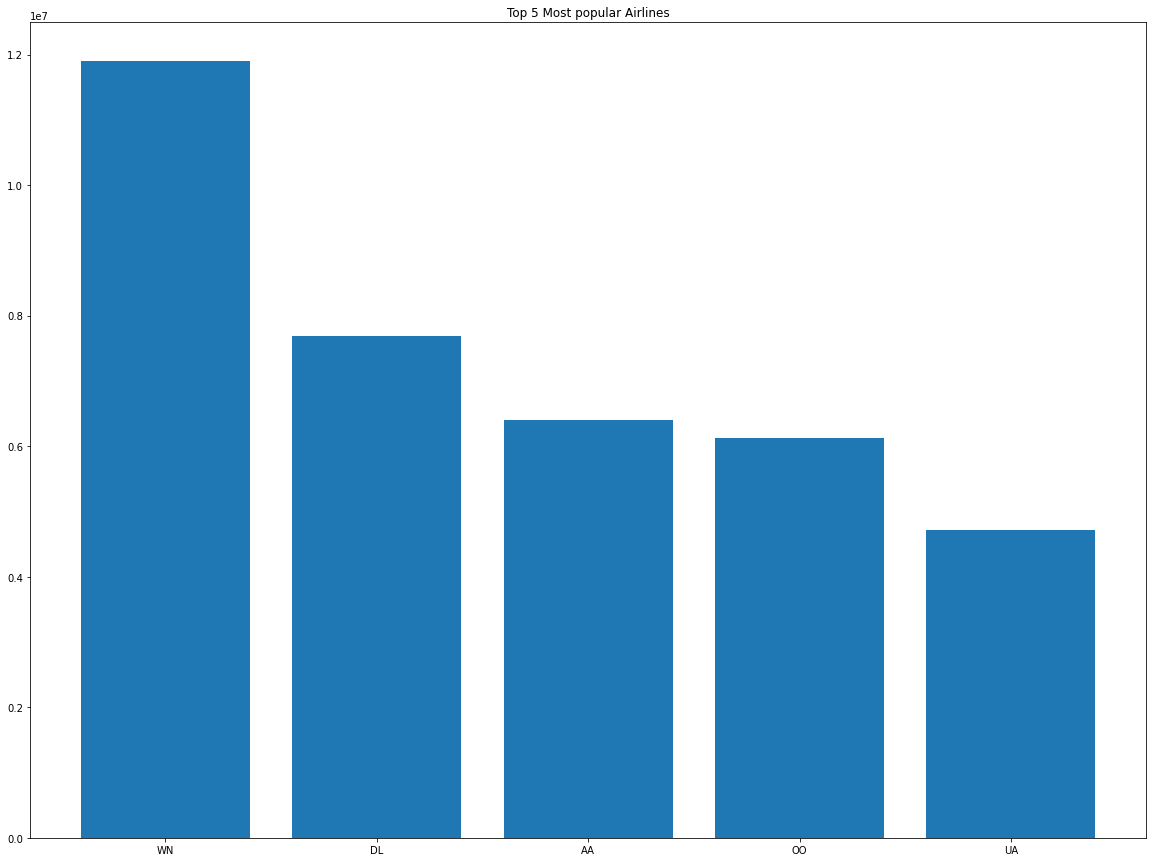

In [21]:
df_temp = df.groupby('OP_CARRIER').count().orderBy('count', ascending=[0]).toPandas()
plt.subplots(figsize = (20,15))
plt.title('Top 5 Most popular Airlines')
plt.bar(df_temp['OP_CARRIER'][0:5], df_temp['count'][0:5])

In [10]:
df_WN = df.filter(df.OP_CARRIER == 'WN').groupby('Year','Month').agg({"AVG_DELAY":"mean"}).orderBy(['Year', 'Month']).toPandas()


In [29]:
df_WN

,Year,Month,avg(AVG_DELAY)
0,2009,1,3.897698
1,2009,2,1.279657
2,2009,3,5.296224
3,2009,4,5.674670
4,2009,5,5.713590
...,...,...,...
113,2018,8,9.137946
114,2018,9,3.943080
115,2018,10,4.961411
116,2018,11,6.118349


In [11]:
df_DL = df.filter(df.OP_CARRIER == 'DL').groupby('Year','Month').agg({"AVG_DELAY":"mean"}).orderBy(['Year', 'Month']).toPandas()


In [12]:
df_AA = df.filter(df.OP_CARRIER == 'AA').groupby('Year','Month').agg({"AVG_DELAY":"mean"}).orderBy(['Year', 'Month']).toPandas()


In [13]:
df_OO = df.filter(df.OP_CARRIER == 'OO').groupby('Year','Month').agg({"AVG_DELAY":"mean"}).orderBy(['Year', 'Month']).toPandas()

In [14]:
df_UA = df.filter(df.OP_CARRIER == 'UA').groupby('Year','Month').agg({"AVG_DELAY":"mean"}).orderBy(['Year', 'Month']).toPandas()


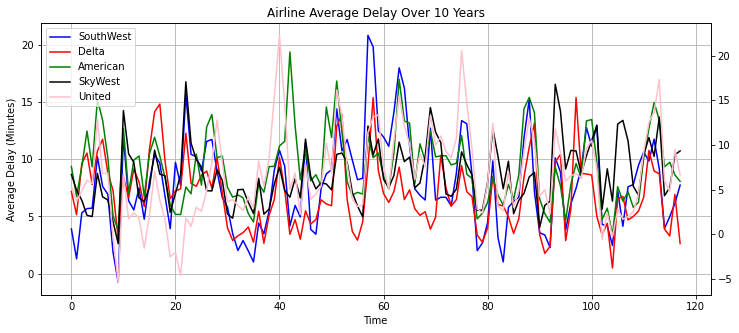

In [18]:
plt.figure(figsize=(12,5))
plt.xlabel('Time')
plt.ylabel('Average Delay (Minutes)')
plt.title("Airline Average Delay Over 10 Years")

ax1 = df_WN['avg(AVG_DELAY)'].plot(color='blue', grid=True, label='SouthWest')
ax2 = df_DL['avg(AVG_DELAY)'].plot(color='red', grid=True, secondary_y=True, label='Delta')
ax3 = df_AA['avg(AVG_DELAY)'].plot(color='green', grid=True, secondary_y=True, label='American')
ax4 = df_OO['avg(AVG_DELAY)'].plot(color='black', grid=True, secondary_y=True, label='SkyWest')
ax5 = df_UA['avg(AVG_DELAY)'].plot(color='pink', grid=True, secondary_y=True, label='United')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
h3, l3 = ax3.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

We can clearly see some seasonality, indicating that generating the season column is probably a good choice. 
On the extreme end, we see that both SouthWest Airline and United Airline have the largest and lowest average delays. This could be an indication of its poor scheduling management over their aircrafts. On the other hand, SkyWest has the most consistent average delays, refelcting a better aircraft management over others.

Overall, we don't see an improvement of these airline delays over time. Perhaps the underlying system of their aircraft scheduling didn't change.  

In [12]:
df.dtypes

[('FL_DATE', 'date'),
 ('OP_CARRIER', 'string'),
 ('OP_CARRIER_FL_NUM', 'string'),
 ('ORIGIN', 'string'),
 ('DEST', 'string'),
 ('CRS_DEP_TIME', 'int'),
 ('DEP_DELAY', 'double'),
 ('TAXI_OUT', 'double'),
 ('TAXI_IN', 'double'),
 ('CRS_ARR_TIME', 'int'),
 ('ARR_DELAY', 'double'),
 ('CANCELLED', 'boolean'),
 ('DIVERTED', 'boolean'),
 ('CRS_ELAPSED_TIME', 'int'),
 ('AIR_TIME', 'double'),
 ('DISTANCE', 'double'),
 ('OR_AIRPORT_NAME', 'string'),
 ('OR_CITY', 'string'),
 ('OR_COUNTRY', 'string'),
 ('OR_AIRPORT_CODE', 'string'),
 ('OR_LATITUDE', 'double'),
 ('OR_LONGTITUDE', 'double'),
 ('DES_AIRPORT_NAME', 'string'),
 ('DES_CITY', 'string'),
 ('DES_COUNTRY', 'string'),
 ('DES_AIRPORT_CODE', 'string'),
 ('DES_LATITUDE', 'double'),
 ('DES_LONGTITUDE', 'double'),
 ('AVG_DELAY', 'double'),
 ('Season', 'string'),
 ('Year', 'int'),
 ('Month', 'int')]

### Visualizing Airport Traffic

In [14]:
df_temp = df.groupby("ORIGIN", "OR_LONGTITUDE", "OR_LATITUDE","OR_AIRPORT_NAME").count().orderBy("count", ascending = [0]).toPandas()
df_temp

,ORIGIN,OR_LONGTITUDE,OR_LATITUDE,OR_AIRPORT_NAME,count
0,ATL,-84.428101,33.636700,Hartsfield Jackson Atlanta International Airport,3824282
1,ORD,-87.904800,41.978600,Chicago O'Hare International Airport,2906311
2,DFW,-97.038002,32.896801,Dallas Fort Worth International Airport,2482216
3,DEN,-104.672997,39.861698,Denver International Airport,2271252
4,LAX,-118.407997,33.942501,Los Angeles International Airport,2106076
...,...,...,...,...,...
363,PIR,-100.286003,44.382702,Pierre Regional Airport,3
364,YNG,-80.679100,41.260700,Youngstown Warren Regional Airport,2
365,MCN,-83.649200,32.692799,Middle Georgia Regional Airport,2
366,TUP,-88.769897,34.268101,Tupelo Regional Airport,1
